In [1]:
import datetime
import glob
from functools import lru_cache, partial
from pprint import pprint

import gym_trading_env
import gymnasium as gym
import matplotlib.pyplot as plt
import MultiTrade
import numpy as np
import pandas as pd
import torch
from gym_trading_env.downloader import download
from gym_trading_env.environments import TradingEnv

from gym_trading_env.renderer import Renderer
from IPython.display import display
from ray import train, tune
from tqdm.autonotebook import tqdm
from utils.utils import build_dataset, build_market_image,preprocess_data
from utils.forecast_utils import build_model_get_data,get_dataset_columns

import ray

from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
)

import warnings
warnings.filterwarnings("ignore")

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.numpy import mae, mse

In [2]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='ETHUSDT'
time_frame="1h"

In [3]:
data=build_market_image(target_pair='ETH/USDT',time_frame='1h',axis=0)
data
data=data.groupby('symbol').apply(lambda x: x[:pd.Timestamp('2024-01-01')])

# # data.to_csv('data/binance-market-1h.csv')

# data=data.groupby('symbol').apply(lambda x: x[:pd.Timestamp('2024-01-01')])

data=data.reset_index(level=0,drop=True).reset_index()
data=data[data['symbol']=='ETHUSDT'].copy()
data['symbol'].unique()
id_columns=['symbol']
output_columns,feature_columns,drop_columns=get_dataset_columns(data,id_columns=['symbol'])
len(output_columns)+len(data[id_columns[0]].unique())

2

In [4]:
data

,date_open,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,...,feature_log_return_15,feature_log_volume_15,feature_log_return_20,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,unique_id,symbol
140112,2022-01-01 06:00:00,2831.117702,2814.083234,2826.553006,2807.447705,5239.0026,2807.447705,1.260870,1.833333,1.0,...,1.562115,43.570511,1.831037,43.934894,1.526594,43.909164,1.966480,42.248218,8,ETHUSDT
140113,2022-01-01 07:00:00,2807.447702,2796.343234,2819.223006,2810.837705,6541.6499,2810.837705,1.304348,1.833333,1.0,...,1.562115,43.570511,1.831037,43.934894,1.526594,43.909164,1.966480,42.248218,8,ETHUSDT
140114,2022-01-01 08:00:00,2810.837702,2805.253234,2826.823006,2816.927705,4013.6403,2816.927705,1.347826,1.833333,1.0,...,1.562115,43.570511,1.831037,43.934894,1.526594,43.909164,1.966480,42.248218,8,ETHUSDT
140115,2022-01-01 09:00:00,2816.657702,2801.413234,2827.603006,2814.197705,4515.6636,2814.197705,1.391304,1.833333,1.0,...,1.562115,43.570511,1.831037,43.934894,1.526594,43.909164,1.966480,42.248218,8,ETHUSDT
140116,2022-01-01 10:00:00,2814.187702,2803.293234,2791.683006,2786.917705,10412.4737,2786.917705,1.434783,1.833333,1.0,...,1.562115,43.570511,1.831037,43.934894,1.526594,43.909164,1.966480,42.248218,8,ETHUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157621,2023-12-31 20:00:00,1390.347702,1366.243234,1398.503006,1377.927705,12876.9660,1377.927705,1.869565,2.000000,2.0,...,1.562851,44.647825,1.822908,44.607587,1.518969,44.426928,1.957981,42.306777,8,ETHUSDT
157622,2023-12-31 21:00:00,1377.917702,1364.163234,1398.333006,1378.727705,7392.8667,1378.727705,1.913043,2.000000,2.0,...,1.561510,44.305463,1.828150,43.987003,1.519876,43.798841,1.953525,41.875121,8,ETHUSDT
157623,2023-12-31 22:00:00,1378.727702,1365.403234,1377.103006,1370.297705,18374.1473,1370.297705,1.956522,2.000000,2.0,...,1.553343,44.252925,1.826274,44.827855,1.514921,45.274453,1.951029,42.610113,8,ETHUSDT
157624,2023-12-31 23:00:00,1370.277702,1355.833234,1390.713006,1377.397705,10288.4085,1377.397705,2.000000,2.000000,2.0,...,1.556429,43.991844,1.830095,44.576480,1.523990,44.269318,1.955063,42.092090,8,ETHUSDT


In [5]:

data['ds']=data['date_open']
data=data.drop(['date_open','symbol'],axis=1)
front=['y','ds','unique_id']
data=data[front+[c for c in data.columns if c not in front]]
data=data[front]

In [6]:
data

,y,ds,unique_id
140112,2807.447705,2022-01-01 06:00:00,8
140113,2810.837705,2022-01-01 07:00:00,8
140114,2816.927705,2022-01-01 08:00:00,8
140115,2814.197705,2022-01-01 09:00:00,8
140116,2786.917705,2022-01-01 10:00:00,8
...,...,...,...
157621,1377.927705,2023-12-31 20:00:00,8
157622,1378.727705,2023-12-31 21:00:00,8
157623,1370.297705,2023-12-31 22:00:00,8
157624,1377.397705,2023-12-31 23:00:00,8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


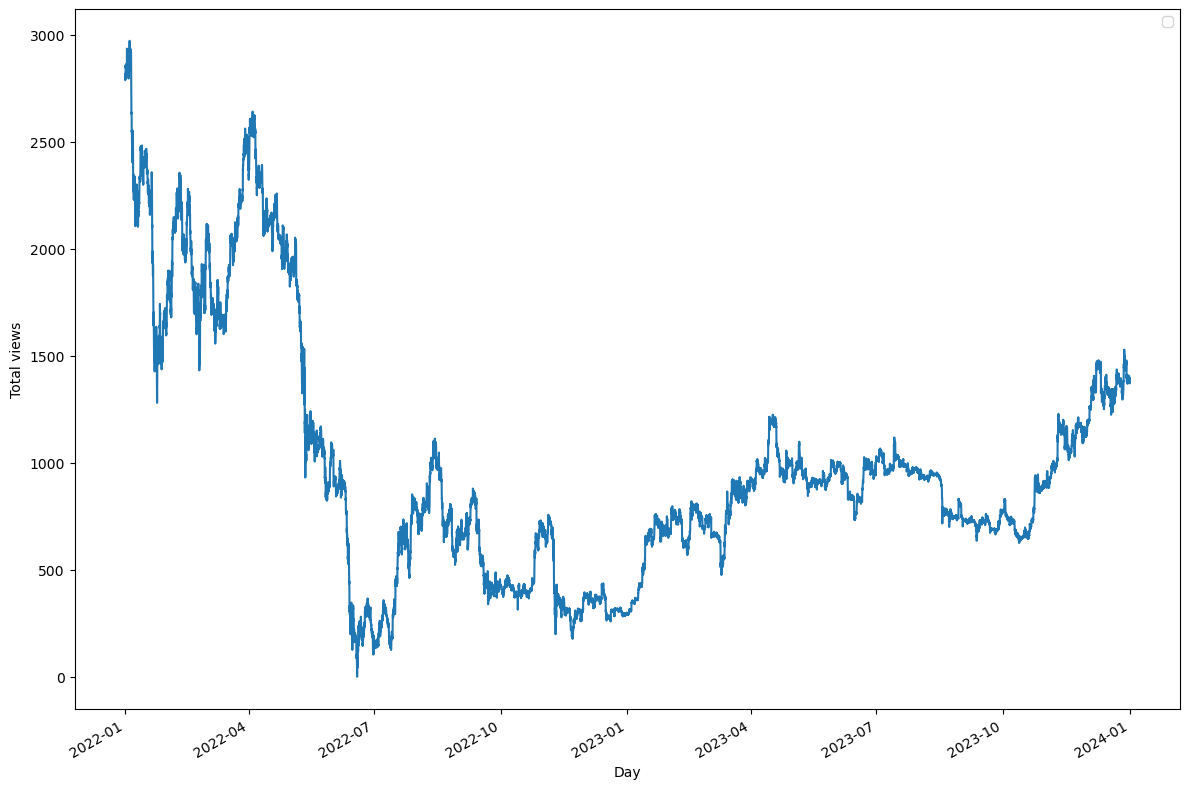

In [7]:


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(data['ds'], data['y'])
# ax.scatter(data['ds'], data['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

In [8]:
split=int(len(data)*.7)
print(split)
train = data[:split]
test = data[split:]
future_exog = test[['unique_id','y']]


12259


In [9]:
horizon = 7
context_length=5*horizon
max_steps=2000
models = [NHITS(h=horizon,
               input_size=context_length,
               max_steps=20000,
               enable_progress_bar=False
               ),
         NBEATS(h=horizon,
               input_size=context_length,
               max_steps=20000,
               enable_progress_bar=False
               
               ),
         PatchTST(h=horizon,
                 input_size=context_length,
                 max_steps=20000,
               enable_progress_bar=False
                 
                 )
                 ]
nf = NeuralForecast(models=models,

                     freq='1h')

Seed set to 1
Seed set to 1
Seed set to 1


In [11]:
nf.fit(train,
        val_size=horizon,
        time_col='ds',                    
        target_col='y',
        
        )


In [12]:
nf.save('C:/Users/standard/Git/MultiTrader/forecaster_pretrain/neuralForecast')

In [13]:
from utilsforecast.plotting import plot_series
from statsforecast import StatsForecast

In [14]:

Y_pred = nf.predict().reset_index()
preds_df=Y_pred
preds_df['mean_pred']=preds_df[['NHITS', 'NBEATS','PatchTST']].mean(1)
preds_df= preds_df.merge(test, how='left', on=['unique_id', 'ds'])
preds_df=pd.concat([train.tail(48),preds_df])
preds_df

,y,ds,unique_id,NHITS,NBEATS,PatchTST,mean_pred
152323,875.327705,2023-05-25 02:00:00,8,NaN,NaN,NaN,NaN
152324,876.797705,2023-05-25 03:00:00,8,NaN,NaN,NaN,NaN
152325,874.697705,2023-05-25 04:00:00,8,NaN,NaN,NaN,NaN
152326,879.687705,2023-05-25 05:00:00,8,NaN,NaN,NaN,NaN
152327,879.607705,2023-05-25 06:00:00,8,NaN,NaN,NaN,NaN
152328,874.207705,2023-05-25 07:00:00,8,NaN,NaN,NaN,NaN
152329,880.517705,2023-05-25 08:00:00,8,NaN,NaN,NaN,NaN
152330,882.887705,2023-05-25 09:00:00,8,NaN,NaN,NaN,NaN
152331,881.757705,2023-05-25 10:00:00,8,NaN,NaN,NaN,NaN
152332,885.177705,2023-05-25 11:00:00,8,NaN,NaN,NaN,NaN


In [15]:
def plot_preds(plotting_df,col='mean_pred',cut=False):
    plotting_df=plotting_df.reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(plotting_df['ds'], plotting_df['y'], label='True')

    plot_col='cutoff' if (('cutoff' in plotting_df.columns) and (cut)) else 'ds'
    plt.plot(plotting_df[plot_col], plotting_df[col], label='Forecast')
    # plt.axvline(preds_df['ds'].iloc[horizon], color='black', linestyle='--', label='Train-Test Split')
    plt.xlabel('Timestamp [t]')
    plt.ylabel('Eth_price')
    plt.grid()
    plt.legend()
    


In [16]:
model=nf.models[0]
model.max_steps
test_df=test.reset_index(drop=True)
nf.models[0].step_size

1

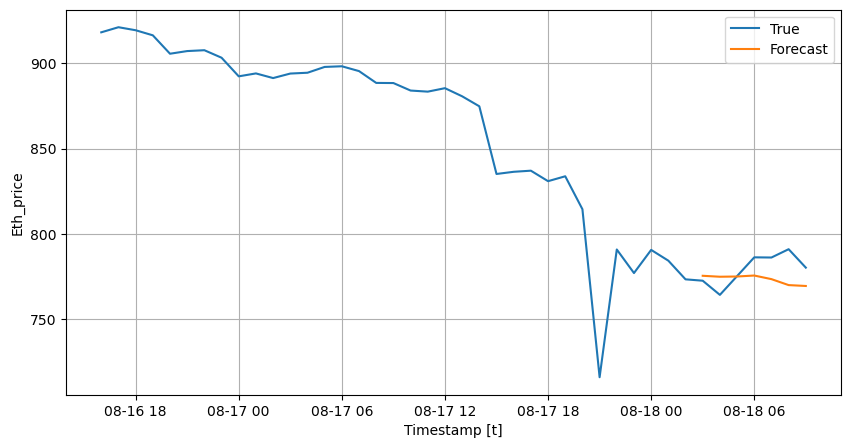

In [17]:
plot_size=500
context_length=5*horizon
end=np.random.randint(0,len(test)-plot_size)
end=end if end>0 else 1
start=end-context_length if (end-context_length)>0 else 0
pred_ids=test_df.index[start:end]
df=test_df.loc[pred_ids]
df=df[['ds','unique_id','y']]
df_plot=test_df.iloc[start:end+horizon].copy().reset_index(drop=True)

nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(df,
                static_df=None, 
                sort_df=None,
                predict_only=False,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')


preds_array=np.array([model.predict(nf.dataset) for model in nf.models]).squeeze().mean(0)

# preds_array
df_plot['mean_pred']=np.nan
n_values=int(-preds_array.shape[0])
ids=df_plot.index[n_values:]
df_plot.loc[ids,'mean_pred']=[c for c in preds_array]

plot_preds(df_plot)
# df

In [18]:
nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(test_df,
                static_df=None, 
                sort_df=None,
                predict_only=False,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')

In [22]:
from itertools import Counter

ImportError: cannot import name 'Counter' from 'itertools' (unknown location)

In [29]:
all_predictions=nf.predict_insample()


In [35]:
all_predictions['ds']

unique_id
8   2023-05-27 02:00:00
8   2023-05-27 03:00:00
8   2023-05-27 04:00:00
8   2023-05-27 05:00:00
8   2023-05-27 06:00:00
            ...        
8   2023-12-31 20:00:00
8   2023-12-31 21:00:00
8   2023-12-31 22:00:00
8   2023-12-31 23:00:00
8   2024-01-01 00:00:00
Name: ds, Length: 36743, dtype: datetime64[ns]

In [43]:

forecasts_series=all_predictions.groupby('cutoff').apply(lambda x: x.select_dtypes(np.number).values.flatten())
forecasts_array=[c for c in forecasts_series]

new_df=test_df[test_df['ds'].isin([c for c in forecasts_series.index])]
print(len(test_df),len(forecasts_array),len(new_df))

5255 5249 5248


In [ ]:
for model in nf.models:
    model.enable_progress_bar=False

In [ ]:
nf.dataset, nf.uids, nf.last_dates, nf.ds=nf._prepare_fit(test_df[['ds','unique_id','y']].tail(horizon),
                static_df=None, 
                sort_df=None ,
                predict_only=True,
                id_col='unique_id', 
                time_col='ds', 
                target_col='y')

In [ ]:
i=0
test_df=test.reset_index(drop=True)
test_df.tail(horizon)


In [ ]:
nf.

In [ ]:
future=nf.make_future_dataframe()
nf.predict()

In [ ]:
test_pred_df=nf.predict_insample().reset_index()
test_pred_df['mean_pred']=test_pred_df[['NHITS', 'NBEATS','PatchTST']].mean(1)
# test_pred_df['mean_pred']=test_pred_df[['mean_pred']].rolling(horizon).mean(1)
test_pred_df


In [ ]:
plot_preds(test_pred_df)
# test_pred_df


In [ ]:
plot_size=500
start=np.random.randint(0,len(test)-plot_size)
plot_df=test_pred_df.iloc[start:start+plot_size]
plot_df=plot_df.sort_values('ds')
# plot_df=plot_df.groupby('cutoff').mean()
plot_df['mean_pred']=plot_df[['mean_pred']].rolling(horizon).mean()
plot_preds(plot_df,cut=True)

In [ ]:
groups=plot_df.groupby('cutoff')
i=0
max_i=10
for name, df in groups:
    i+=1
    display(df)
    if i>max_i:
        break

In [ ]:
plot_df.groupby('cutoff')['mean_pred'].mean()

In [ ]:
preds_df[['mean_pred','y']].plot()

In [ ]:
preds_df = preds_df.round({
    'NHITS': 4,
    'NBEATS': 4,
    'PatchTST': 4,

})

data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'PatchTST': [mae(preds_df['PatchTST'], preds_df['y']), mse(preds_df['PatchTST'], preds_df['y'])],
       }

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

In [ ]:
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)